In [3]:
#%pip install numpy
#%pip install pandas
#%pip install pickle
#%pip install ipywidgets
#%pip install matplotlib
import numpy as np
import pandas as pd
import pickle
from ipywidgets import interact
import matplotlib.pyplot as plt
#%pip install pyarrow
##%pip install fastparquet

### J'ai des pb avec lire les pickles sur mon google drive donc je laisse de téco pr l'instant


In [4]:
df0 = pd.read_parquet('pass0.parquet')
df1 = pd.read_parquet('pass1.parquet')

In [5]:
print(list(df0))
df0.head()

['IRI_mean', 'IRI_sequence', 'GM.TS_or_Distance', 'GM.T', 'GM.lat_int', 'GM.lon_int', 'GM.acc.xyz.z', 'GM.acc.xyz.y', 'GM.acc.xyz.x', 'GM.obd.spd_veh.value']


,IRI_mean,IRI_sequence,GM.TS_or_Distance,GM.T,GM.lat_int,GM.lon_int,GM.acc.xyz.z,GM.acc.xyz.y,GM.acc.xyz.x,GM.obd.spd_veh.value
0,4.933540,"[6.644882798499999, 5.5573473115, 7.666319952,...","[2021-04-22T01:21:54.349000000, 2021-04-22T01:...","[acc.xyz, acc.xyz, acc.xyz, acc.xyz, obd.spd_v...","[55.654713308383236, 55.65471373053892, 55.654...","[12.486686901197604, 12.486686532934131, 12.48...","[0.9727, 0.9727, 0.9727, 0.9727, 0.9922, 0.992...","[-0.1172, -0.1172, -0.1172, -0.1172, -0.1211, ...","[0.1602, 0.1602, 0.1602, 0.1602, 0.1563, 0.156...","[31.04, 31.0, 30.970000000000002, 31.470000000..."
1,4.696225,"[5.5573473115, 7.666319952, 4.1605364705, 5.35...","[2021-04-22T01:21:55.068000000, 2021-04-22T01:...","[acc.xyz, acc.xyz, acc.xyz, acc.xyz, acc.xyz, ...","[55.654781462897525, 55.65478160070671, 55.654...","[12.48662899293286, 12.486628876325089, 12.486...","[0.9727, 0.9727, 0.9727, 0.9727, 0.9727, 0.972...","[-0.0898, -0.0898, -0.0898, -0.0898, -0.0898, ...","[0.1406, 0.1406, 0.1406, 0.1406, 0.1406, 0.140...","[29.52, 29.48, 29.42, 29.400000000000002, 29.3..."
2,4.699145,"[7.666319952, 4.1605364705, 5.359907053000001,...","[2021-04-22T01:21:56.327000000, 2021-04-22T01:...","[acc.xyz, acc.xyz, acc.xyz, acc.xyz, acc.xyz, ...","[55.654862308917195, 55.65486260509554, 55.654...","[12.486560579617835, 12.486560331210192, 12.48...","[1.0391, 1.0391, 1.0391, 1.0391, 1.0391, 1.015...","[0.0273, 0.0273, 0.0273, 0.0273, 0.0273, 0.011...","[0.1523, 0.1523, 0.1523, 0.1523, 0.1523, 0.160...","[30.080000000000002, 30.14, 30.2, 30.23, 29.54..."
3,4.397566,"[4.1605364705, 5.359907053000001, 4.5512844555...","[2021-04-22T01:21:57.983000000, 2021-04-22T01:...","[acc.xyz, acc.xyz, acc.xyz, acc.xyz, acc.xyz, ...","[55.654942544169614, 55.65494265017668, 55.654...","[12.486492964664311, 12.486492879858657, 12.48...","[1.0391, 1.0391, 0.9805, 0.9805, 0.9805, 0.980...","[0.1016, 0.1016, 0.0898, 0.0898, 0.0898, 0.089...","[0.2188, 0.2188, 0.1953, 0.1953, 0.1953, 0.195...","[36.910000000000004, 37.0, 37.07, 37.18, 37.25..."
4,4.400549,"[5.359907053000001, 4.5512844555, 5.8527534034...","[2021-04-22T01:21:59.120000000, 2021-04-22T01:...","[obd.spd_veh, acc.xyz, acc.xyz, acc.xyz, acc.x...","[55.65502238338658, 55.65502269329073, 55.6550...","[12.486424923322684, 12.486424661341852, 12.48...","[0.9492, 0.9961, 0.9961, 0.9961, 0.9961, 0.996...","[0.0859, 0.0977, 0.0977, 0.0977, 0.0977, 0.097...","[0.1875, 0.1563, 0.1563, 0.1563, 0.1563, 0.156...","[41.2, 41.27, 41.38, 41.46, 41.53, 40.76, 41.6..."


In [6]:
def show(col):
    try:
        plt.hist(df0[col].map(len), bins=20)
        plt.show()
        plt.plot(df0.loc[0,col])
    except:
        ...#reeee
    
interact(show, col=list(df0));

interactive(children=(Dropdown(description='col', options=('IRI_mean', 'IRI_sequence', 'GM.TS_or_Distance', 'G…

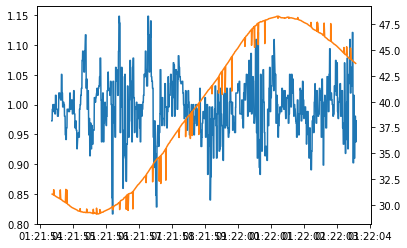

In [7]:
s0 = df0.loc[0]
mask = s0['GM.T'] == 'acc.xyz'
accT = s0['GM.TS_or_Distance'][mask]
accZ = s0['GM.acc.xyz.z']
obdT = s0['GM.TS_or_Distance'][~mask]
obd = s0['GM.obd.spd_veh.value']

# plt.plot(accZ)
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(accT, accZ, color='#1f77b4')
ax2.plot(obdT, obd, color='#ff7f0e');

# weird stuff on the orange curve (?)

In [110]:
from torch.utils.data import Dataset

class MyDS(Dataset):
    def __init__(self, fname, size=None):
        df = fname
        zacc = df['GM.acc.xyz.z'] # Series[arr[:]float]
        
        if not size:
            size = zacc.map(len).quantile(.1)
            size = (int(size) // 32) * 32
        self.sz = size
        zacc = zacc[zacc.map(len) >= size]
        
        def truncate(arr):
            return arr[:size]
        zacc = np.stack(zacc.map(truncate)).astype('float32')
        # print(zacc.shape, size)
        self.zacc = zacc
        
    
    def __getitem__(self, idx):
        return self.zacc[idx][None,:]
    
    def __len__(self):
        return len(self.zacc)

L = 2048
my_data = MyDS(df0, L) #size = N

In [289]:
import torch
import torch.nn as nn 

class AE(nn.Module):
    def __init__(self, hidden_units, num_features, L,latent_features=3):
        super().__init__()
        
        mid = L // (4*4*4) #latent space dims
        assert L % (4*4*4) == 0
        
        self.encoder = nn.Sequential(
            
            nn.LSTM(input_size =num_features, hidden_size =hidden_units),
            nn.ReLU(),
            # bottleneck layer
            nn.Linear(in_features=hidden_units, out_features=latent_features)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_features, out_features=hidden_units),
            nn.ReLU(),
            # output layer, projecting back to image size
            nn.LSTM(input_size =hidden_units, hidden_size =num_features)
        )
  
    def forward(self, x):
        encoded = self.encoder(x)
        # print(encoded.shape)
        decoded = self.decoder(encoded)
        return decoded
        
    def get_latent(self,x):
        return self.encoder(x)

In [298]:
class Encoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(Encoder, self).__init__()
        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim
        self.rnn1 = nn.LSTM(
          input_size=n_features,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )
        self.rnn2 = nn.LSTM(
          input_size=self.hidden_dim,
          hidden_size=embedding_dim,
          num_layers=1,
          batch_first=True
        )
    def forward(self, x):
        #x = x.reshape((1, self.seq_len, self.n_features))
        x, (_, _) = self.rnn1(x)
        x, (hidden_n, _) = self.rnn2(x)
        return hidden_n#.reshape((self.n_features, self.embedding_dim))

    def get_latent(self,x):
        return self.encoder(x)

In [299]:
class Decoder(nn.Module):
    def __init__(self, seq_len, input_dim=64, n_features=1):
        super(Decoder, self).__init__()
        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features = 2 * input_dim, n_features
        self.rnn1 = nn.LSTM(
          input_size=input_dim,
          hidden_size=input_dim,
          num_layers=1,
          batch_first=True
        )
        self.rnn2 = nn.LSTM(
          input_size=input_dim,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )
        self.output_layer = nn.Linear(self.hidden_dim, n_features)
    def forward(self, x):
        #x = x.repeat(self.seq_len, self.n_features)
        #x = x.reshape((self.n_features, self.seq_len, self.input_dim))
        x, (hidden_n, cell_n) = self.rnn1(x)
        x, (hidden_n, cell_n) = self.rnn2(x)
        #x = x.reshape((self.seq_len, self.hidden_dim))
        return self.output_layer(x)

In [300]:
class RecurrentAutoencoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(RecurrentAutoencoder, self).__init__()
        self.encoder = Encoder(seq_len, n_features, embedding_dim)
        self.decoder = Decoder(seq_len, embedding_dim, n_features)
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    def get_latent(self,x):
        return self.encoder(x)

In [301]:
def visualization(x,display = True):
    tsne = TSNE(n_components=2, n_iter=3000, )
    vis = tsne.fit_transform(x)
    if display:
        fig, ax = plt.subplots()
        ax.scatter(*vis.T)
        plt.show()
    else:
        return vis

In [302]:
model = RecurrentAutoencoder(hidden_units, num_features,64)
model

RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(2048, 128, batch_first=True)
    (rnn2): LSTM(128, 64, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(64, 64, batch_first=True)
    (rnn2): LSTM(64, 128, batch_first=True)
    (output_layer): Linear(in_features=128, out_features=2048, bias=True)
  )
)

In [303]:
from torch.utils.data import DataLoader
#in_channels = 
#out_channels = 
#kernel_size= 
num_features = L
hidden_units = 248
n_features =10
dataloader = DataLoader(my_data, shuffle=True)
do_run = False
do_run = True
if (do_run):
    #model = AE(hidden_units,num_features,L)

    model = RecurrentAutoencoder(hidden_units, num_features, n_features)

    loss_fn = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

    loss_array = []
    for x in dataloader:

        pred = model(x)
        loss = loss_fn(pred, x)

        #optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_array.append(float(loss))
        print(float(loss))

0.9825882911682129
1.014312982559204
1.0143938064575195
1.0108124017715454
1.0221679210662842
1.0140881538391113
1.0067883729934692
1.0071674585342407
1.016016960144043
1.0111451148986816
1.00722074508667
1.0047192573547363
0.9897456765174866
1.017722487449646
1.0085506439208984
0.9950274229049683
1.014415979385376
1.0215519666671753
1.0135555267333984
1.014685869216919
1.0175801515579224
1.013537883758545
1.006961703300476
0.9956464171409607
0.9865243434906006
0.9760779738426208
0.9970970749855042
0.9999382495880127
1.0101007223129272
1.0240285396575928
1.0009979009628296
1.0423790216445923
1.0009721517562866
1.012229084968567
1.007310152053833
1.0082148313522339
1.0126649141311646
1.0082601308822632
1.0084131956100464
0.979839026927948
1.0044339895248413
0.9955016374588013
0.9912174344062805
1.0084888935089111
0.992535412311554
1.0142585039138794
1.0001808404922485
1.0010592937469482
1.0243850946426392
1.0242475271224976
1.0103076696395874
1.008604884147644
1.0026483535766602
1.02257

0.72091144323349
0.7264189124107361
0.7301706075668335
0.7142168283462524
0.7159261703491211
0.718052327632904
0.7166261076927185
0.7040113210678101
0.7154563665390015
0.7081813812255859
0.6983435153961182
0.7122780084609985
0.721800684928894
0.7090908885002136
0.7086620330810547
0.690778911113739
0.6765685677528381
0.7175341844558716
0.6859455108642578
0.6995659470558167
0.7052695751190186
0.6958162188529968
0.6945325136184692
0.7022485136985779
0.6659325957298279
0.703554630279541
0.6912867426872253
0.6972184777259827
0.677516758441925
0.6866362690925598
0.694728434085846
0.6895166039466858
0.6926922798156738
0.6929086446762085
0.6829103231430054
0.6969408392906189
0.6959072947502136
0.6805509328842163
0.6815411448478699
0.673378586769104
0.674738347530365
0.6820111274719238
0.6847951412200928
0.6801813244819641
0.6828705072402954
0.6680526733398438
0.6652224063873291
0.6714205145835876
0.6773443818092346
0.6591564416885376
0.680388867855072
0.6587218642234802
0.6730701327323914
0.65

0.13996919989585876
0.14652246236801147
0.13541021943092346
0.14197686314582825
0.13923713564872742
0.13343100249767303
0.13589757680892944
0.1332283765077591
0.1375904083251953
0.13686709105968475
0.13551345467567444
0.13678890466690063
0.12900282442569733
0.13705827295780182
0.1271248608827591
0.12956993281841278
0.1282750815153122
0.11917193979024887
0.12066778540611267
0.12095003575086594
0.12422685325145721
0.12421801686286926
0.12137363851070404
0.1253097951412201
0.11471670866012573
0.12099796533584595
0.11729317158460617
0.1182393953204155
0.11774420738220215
0.11355653405189514
0.11332365870475769
0.1141870841383934
0.11507680267095566
0.11073844879865646
0.11165469884872437
0.11082938313484192
0.11009711027145386
0.11089278757572174
0.10242969542741776
0.10808427631855011
0.10289027541875839
0.10794834792613983
0.10343123972415924
0.10879866778850555
0.10400562733411789
0.10470686852931976
0.09539179503917694
0.09580591320991516
0.10163811594247818
0.10038838535547256
0.09823

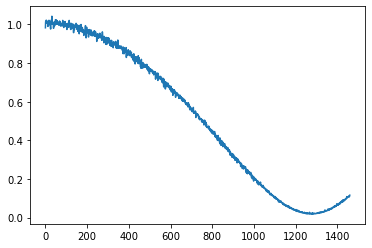

In [304]:
if (do_run):
    steps_plot = np.arange(0,len(loss_array),1)

    plt.plot(steps_plot,loss_array)
    plt.show()

In [305]:
latent = []

for x in dataloader:
    x = torch.reshape(x,(1,L))
    latent.append(model.get_latent(x).detach().numpy()[0])
print(len(latent))
print(latent[0])
visualization(latent)

RuntimeError: input must have 3 dimensions, got 2